In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ltfs-finhack3/train_bureau.csv
/kaggle/input/ltfs-finhack3/train_data.csv
/kaggle/input/ltfs-finhack3/test_data.csv
/kaggle/input/ltfs-finhack3/test_bureau.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import colorama  # https://pypi.python.org/pypi/colorama
import xgboost as xgb
import lightgbm as lgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, pyll
import category_encoders as ce
import pickle
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, f1_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import random
import os
from collections import Counter

In [3]:
obj_call_count = 0
cur_best_score = -np.inf
NB_CV_FOLDS = 3
NUM_OF_BOOST_ROUND = 10000
EARLY_STOPPING = 300
OOF_PREDICTION = True
NUM_OF_SPLITS = 5 # Used for OOF Prediction 
TRAIN_ON_FULL_DATA = True
hyperopt_params = []
MAX_EVALS = 10
FIND_BEST_HYPERPARAMETERS = False
TARGET_ENCODING = False

In [4]:
SEED = 2021

random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

# Loading pre-converted .xlsx file to | (pipe) seperated file for faster loading of data

In [5]:
train_data = pd.read_csv('/kaggle/input/ltfs-finhack3/train_data.csv', sep='|')
train_bureau = pd.read_csv('/kaggle/input/ltfs-finhack3/train_bureau.csv', sep='|')
test_data = pd.read_csv('/kaggle/input/ltfs-finhack3/test_data.csv', sep='|')
test_bureau = pd.read_csv('/kaggle/input/ltfs-finhack3/test_bureau.csv', sep='|')
sample_sub = test_data[['ID']].copy()

In [6]:
print("TRAIN",train_data.shape, train_bureau.shape)
print("TEST:",test_data.shape, test_bureau.shape)

TRAIN (128655, 26) (560844, 25)
TEST: (14745, 25) (64019, 25)


In [7]:
train_data.columns

Index(['ID', 'Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode',
       'BranchID', 'Area', 'Tenure', 'AssetCost', 'AmountFinance',
       'DisbursalAmount', 'EMI', 'DisbursalDate', 'MaturityDAte', 'AuthDate',
       'AssetID', 'ManufacturerID', 'SupplierID', 'LTV', 'SEX', 'AGE',
       'MonthlyIncome', 'City', 'State', 'ZiPCODE', 'Top-up Month'],
      dtype='object')

In [8]:
train_bureau.columns

Index(['ID', 'SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE',
       'DATE-REPORTED', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'DISBURSED-DT',
       'CLOSE-DT', 'LAST-PAYMENT-DATE', 'CREDIT-LIMIT/SANC AMT',
       'DISBURSED-AMT/HIGH CREDIT', 'INSTALLMENT-AMT', 'CURRENT-BAL',
       'INSTALLMENT-FREQUENCY', 'OVERDUE-AMT', 'WRITE-OFF-AMT', 'ASSET_CLASS',
       'REPORTED DATE - HIST', 'DPD - HIST', 'CUR BAL - HIST',
       'AMT OVERDUE - HIST', 'AMT PAID - HIST', 'TENURE'],
      dtype='object')

In [9]:
train_data['Top-up Month'].value_counts()/train_data.shape[0]

No Top-up Service    0.829171
 > 48 Months         0.065027
36-48 Months         0.028417
24-30 Months         0.027142
30-36 Months         0.023800
18-24 Months         0.018406
12-18 Months         0.008037
Name: Top-up Month, dtype: float64

In [10]:
train_bureau['AMT PAID - HIST'].value_counts()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,                  63203
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,                   44600
,                                                      41773
,,,,,,,,,,,,,,                                         13911
,,                                                     11439
                                                       ...  
,,,,,,,,,,,,,,,,,,,,,,,1062,                               1
,,,,3409,,,,,,,,,,,,                                       1
118569,0,0,0,0,0,0,0,0,,0,0,0,                             1
,,,,,,,,,,2145,,,,,,,,,,,,,,100000,17931,,,,,,,,,,,        1
74700,,,,,,,,,,,412,,,,,,,,3046,,,,,,,,,,,,,,,,,           1
Name: AMT PAID - HIST, Length: 83417, dtype: int64

In [11]:
def extract_past_dues(data):
    if 'E' in data:
        data = "{}".format(int(float(data)))
    data = data.replace('D', '0')
    data = data.replace('X', '0')
    tokens = [int(data[i:i+3]) for i in range(0,len(data),3)]
    #print(tokens)
    return tokens

def extract_past_payments(data):
    tokens = [ 0 if len(_)==0 else float(_) for _ in data.split(',')]
    return tokens


def extract_past_dues_12_months(data):
    past_dues_tokens = extract_past_dues(data)[:12]
    return past_dues_tokens

def extract_past_dues_24_months(data):
    past_dues_tokens = extract_past_dues(data)[:24]
    return past_dues_tokens

def extract_past_payments_12_months(data):
    tokens = extract_past_payments(data)[:12]
    return tokens

def extract_past_payments_24_months(data):
    tokens = extract_past_payments(data)[:24]
    return tokens


def average_dues_12_months(data):
    past_dues_tokens = extract_past_dues_12_months(data)
    return sum(past_dues_tokens)/12

def average_dues_24_months(data):
    past_dues_tokens = extract_past_dues_24_months(data)
    return sum(past_dues_tokens)/24

def average_past_payments_12_months(data):
    past_dues_tokens = extract_past_payments_12_months(data)
    return sum(past_dues_tokens)/12

def average_past_payments_24_months(data):
    past_dues_tokens = extract_past_payments_24_months(data)
    return sum(past_dues_tokens)/24

In [12]:
extract_past_payments(',,,100,200')

[0, 0, 0, 100.0, 200.0]

In [13]:
extract_past_dues('000000DDD054024024000000000000000000')

[0, 0, 0, 54, 24, 24, 0, 0, 0, 0, 0, 0]

In [14]:
average_dues_24_months('000000DDD054024024000000000000000000')

4.25

In [15]:
# train_bureau['DPD - HIST'].dropna().apply(average_dues_24_months)

In [16]:
def check_due_past_payment(data):
    for _ in ['1','2','3','4','5','6','7','8','9']:
        if _ in data:
            return True
    return False    
    
def fetch_amount(data):
    raw_token = data.split(',')
    token = []
    for _ in raw_token:
        if len(_) == 0:
            token.append(0)
        else:
            token.append(float(_))
    return sum(token)

def month_bucket(month):
    if month < 12:
        return  'LESS_THAN_12_BUCKET'
    elif month >= 12 and month < 18:
        return '12_18_BUCKET'
    elif month >= 18 and month < 24:
        return '18_24_BUCKET'
    elif month >= 24 and month < 30:
        return '24_30_BUCKET'
    elif month >= 30 and month < 36:
        return '30_36_BUCKET'
    elif month >= 36 and month < 48:
        return '36_48_BUCKET'
    elif month >= 48:
        return '>48_BUCKET'

    
def make_whole_number(data):
    if str(data).lower() == 'nan':
        return np.nan
    else:
        _data = str(int(data))
        _len_data = len(_data)
        _data = "".join(_data[0] + '0' * (_len_data-1))
        return int(_data)
    
def merge_demographic_bureau_data(input_demo_arg, input_bureau_arg):
    input_demo = input_demo_arg.copy()
    input_bureau = input_bureau_arg.copy()
    print(input_demo.shape, input_bureau.shape)
    
    input_demo.PaymentMode = input_demo.PaymentMode.apply(lambda x: x.split('_')[0])
    
    
    input_demo['AGE_WHEN_LOAN_COMPLETES'] = input_demo['AGE'] + input_demo['Tenure']//12
    
    input_demo['EMI_INCOME_RATO'] = input_demo.EMI / input_demo.MonthlyIncome
     
    input_demo['DisbursalDate'] = pd.to_datetime(input_demo['DisbursalDate'])
    input_bureau['DISBURSED-DT'] = pd.to_datetime(input_bureau['DISBURSED-DT'])
    
    input_bureau = input_bureau[~input_bureau['DISBURSED-AMT/HIGH CREDIT'].isnull()]
    input_bureau['DISBURSED-AMT/HIGH CREDIT___WHOLE_NUMBER'] = input_bureau['DISBURSED-AMT/HIGH CREDIT'].apply(make_whole_number)
    input_bureau['CURRENT-BAL___WHOLE_NUMBER'] = input_bureau['CURRENT-BAL'].apply(make_whole_number)    
    input_bureau['OVERDUE-AMT___WHOLE_NUMBER'] = input_bureau['OVERDUE-AMT'].apply(make_whole_number)    
    input_bureau["WRITE-OFF-AMT___WHOLE_NUMBER"] = input_bureau["WRITE-OFF-AMT"].apply(make_whole_number)
    
    df_merged = pd.merge(input_demo, input_bureau)

    disbursed_dt_isnull_mask = df_merged['DISBURSED-DT'].isnull()
    equal_amount = df_merged['DisbursalAmount'] == df_merged['DISBURSED-AMT/HIGH CREDIT']
    tmp_mask = disbursed_dt_isnull_mask & equal_amount & df_merged['SELF-INDICATOR'] 
    df_merged[tmp_mask]['DISBURSED-DT'] = df_merged[ tmp_mask ]['DisbursalDate']
    
    #Filter where 'DISBURSED-DT' is not null
    disbursed_dt_isnull_mask = df_merged['DISBURSED-DT'].isnull()

    df_merged = df_merged[~disbursed_dt_isnull_mask]
    

    df_merged =  df_merged[df_merged['DISBURSED-AMT/HIGH CREDIT'] <= df_merged['DisbursalAmount']]
    
    df_merged['DPD - HIST'] = df_merged['DPD - HIST'].fillna('000')
    df_merged['ANY_PAST_DUE_DAYS'] = df_merged['DPD - HIST'].astype('str').apply(check_due_past_payment)
    df_merged['AVERAGE_PAST_DUE_DAYS_OF_PAST_12_MONTHS'] = df_merged['DPD - HIST'].apply(average_dues_12_months)    
    df_merged['AVERAGE_PAST_DUE_DAYS_OF_PAST_24_MONTHS'] = df_merged['DPD - HIST'].apply(average_dues_24_months)
    
    #AMT PAID - HIST
    df_merged['AMT PAID - HIST'] = df_merged['AMT PAID - HIST'].fillna(',,,')
#     df_merged['AVERAGE_AMT_PAID_OF_PAST_12_MONTHS'] = df_merged['AMT PAID - HIST'].apply(average_past_payments_12_months)
#     df_merged['AVERAGE_AMT_PAID_OF_PAST_24_MONTHS'] = df_merged['AMT PAID - HIST'].apply(average_past_payments_24_months)
    df_merged['AMT_PAID_HIST_TOTAL'] = df_merged['AMT PAID - HIST'].apply(fetch_amount)

    #AMT OVERDUE - HIST
    df_merged['AMT OVERDUE - HIST'] = df_merged['AMT OVERDUE - HIST'].fillna(',,,')
#     df_merged['AVERAGE_AMT_OVERDUE_OF_PAST_12_MONTHS'] = df_merged['AMT OVERDUE - HIST'].apply(average_past_payments_12_months)
#     df_merged['AVERAGE_AMT_OVERDUE_OF_PAST_24_MONTHS'] = df_merged['AMT OVERDUE - HIST'].apply(average_past_payments_24_months)
    df_merged['AMT_OVERDUE_HIST_TOTAL'] = df_merged['AMT OVERDUE - HIST'].apply(fetch_amount)    
    
    #CUR BAL - HIST
    df_merged['CUR BAL - HIST'] = df_merged['CUR BAL - HIST'].fillna(',,,')
#     df_merged['AVERAGE_CUR_BAL_OF_PAST_12_MONTHS'] = df_merged['CUR BAL - HIST'].apply(average_past_payments_12_months)
#     df_merged['AVERAGE_CUR_BAL_OF_PAST_24_MONTHS'] = df_merged['CUR BAL - HIST'].apply(average_past_payments_24_months)
    df_merged['CUR_BAL_HIST_TOTAL'] = df_merged['CUR BAL - HIST'].apply(fetch_amount)
    
    df_merged['NEXT_LOAN_IN_MONTHS'] = (df_merged['DISBURSED-DT'] - df_merged['DisbursalDate']).apply(lambda x: x/np.timedelta64(1, 'M')).astype('int')
    df_merged['NEXT_LOAN_BUCKET'] = df_merged['NEXT_LOAN_IN_MONTHS'].apply(month_bucket)
    df_merged['OLD_NEW_LOAN_RATIO'] =  df_merged['DISBURSED-AMT/HIGH CREDIT'] / df_merged['DisbursalAmount']
    
    
    other_existing_loan_from_ltfs = (df_merged['NEXT_LOAN_IN_MONTHS'].apply(lambda x: x>=0))
    df_merged = df_merged[other_existing_loan_from_ltfs]
    
           
    cat_features = [
        'MATCH-TYPE', 
        'ACCT-TYPE', 
        'CONTRIBUTOR-TYPE', 
        'OWNERSHIP-IND', 
        'ACCOUNT-STATUS', 
        'ASSET_CLASS',
        'NEXT_LOAN_BUCKET', 
        'SELF-INDICATOR'
    ]
    
    for cat_fe in cat_features:
        print(cat_fe)
        categories = [ cat_fe+"___"+_+"___COUNT" for _ in df_merged[cat_fe].dropna().astype('str').unique()]
        df_merged[categories] = 0
        cat_fe_count_dict = { _:{} for _ in categories}
        for _key, _grp in df_merged.groupby(['ID']):
            tmp = Counter(_grp[cat_fe].dropna().astype('str'))
            for k,v in tmp.items():
                prev_counts = cat_fe_count_dict[cat_fe+"___"+k+"___COUNT"]
                prev_counts[str(_key)] = v
                cat_fe_count_dict[cat_fe+"___"+k+"___COUNT"] = prev_counts
        for new_fe in categories:
            print(new_fe)
            id_to_count_mapping = cat_fe_count_dict[new_fe] 
            df_merged[new_fe] = df_merged['ID'].astype('str').apply(lambda x: id_to_count_mapping[x] if x in id_to_count_mapping else 0)
    

    
    numerical_features = [
        "CREDIT-LIMIT/SANC AMT", 
        "DISBURSED-AMT/HIGH CREDIT",
        "INSTALLMENT-AMT", 
        "CURRENT-BAL",
        "OVERDUE-AMT",
        "WRITE-OFF-AMT",        
        "AMT_PAID_HIST_TOTAL",
        "AMT_OVERDUE_HIST_TOTAL",
        "CUR_BAL_HIST_TOTAL",
        "OLD_NEW_LOAN_RATIO",
        "DISBURSED-AMT/HIGH CREDIT___WHOLE_NUMBER",
        "CURRENT-BAL___WHOLE_NUMBER",
        "OVERDUE-AMT___WHOLE_NUMBER",
        "WRITE-OFF-AMT___WHOLE_NUMBER",
#         "TENURE",
    ]
    
    
    
    
    
    
    agg_col_sep = '____'
    agg_for_customer = {}
    for _agg_col in numerical_features:
        print(_agg_col,'MEAN_PER_CUSTOMER')
        tmp_dict = {}            
        for _key, _grp in df_merged.groupby(['ID']):
            _mean = _grp[_agg_col].mean()
            _str_key = str(_key)
            tmp_dict[_str_key] = _mean
        agg_for_customer[_agg_col+agg_col_sep+"MEAN_PER_CUSTOMER"] = tmp_dict
        
    for agg_keys, agg_values in agg_for_customer.items():
        df_merged[agg_keys] = 0
        filtered_df = df_merged
        fetch_agg_values = filtered_df.ID.astype('str').apply(lambda x: agg_values[x] if x in agg_values else 0.0)
        df_merged.loc[filtered_df.index, agg_keys] = fetch_agg_values

        
    loan_buckets = df_merged['NEXT_LOAN_BUCKET'].unique()
    for num_fe in numerical_features:
        print(num_fe)
        categories = [ num_fe+"___"+_+"___MEAN" for _ in loan_buckets]
        df_merged[categories] = 0
        num_fe_avg_dict = { _:{} for _ in categories}
        for (_id,_loan_bucket), _grp in df_merged.groupby(['ID','NEXT_LOAN_BUCKET']):
            col_mean = _grp[num_fe].mean()
            prev_counts = num_fe_avg_dict[num_fe+"___"+_loan_bucket+"___MEAN"]
            prev_counts[str(_id)] = col_mean
            num_fe_avg_dict[num_fe+"___"+_loan_bucket+"___MEAN"] = prev_counts

        for new_fe in categories:
            print(new_fe)
            id_to_count_mapping = num_fe_avg_dict[new_fe] 
            df_merged[new_fe] = df_merged['ID'].astype('str').apply(lambda x: id_to_count_mapping[x] if x in id_to_count_mapping else 0)
    
    train_id_counts = Counter(df_merged.ID)
    ctr = 0
    single_record_ids = []
    multi_record_ids = []
    for k,v in train_id_counts.items():
        if v>1:
            ctr += 1
            multi_record_ids.append(k)
        else:
            single_record_ids.append(k)

    print("#of IDs have more than 1 records: {} out of {} these IDs".format(ctr, len(train_id_counts)))
    df_merged = df_merged[df_merged.ID.isin(multi_record_ids)]
    
    df_merged = df_merged.sort_values(by=['ID','SELF-INDICATOR','NEXT_LOAN_IN_MONTHS'], ascending=[True, False, False])
#     df_merged = df_merged[(df_merged['NEXT_LOAN_IN_MONTHS'] == 0) & (df_merged['OLD_NEW_LOAN_RATIO'] == 1.0) & (df_merged['SELF-INDICATOR'] == True)]
    
    print("Returning DF.SHAPE:",df_merged.shape)
    return df_merged

# Outlier Treatement:

> * Tried clipping the lower and high values but didn't improve the cross-validation score.

> * Added an extra boolean feature which contains True if value is less than or higher than the IQR (Inter-quantile Range) else False

In [17]:
def outlier_treatement(input_demo, features):
    
    for fe in features:
        
        #CLIPPING MonthlyIncome and finding outliers
        Q1 = input_demo[fe].quantile(.25)
        Q3 = input_demo[fe].quantile(.75)
        Q_10 = input_demo[fe].quantile(0.1)
        Q_90 = input_demo[fe].quantile(0.9)

        IQR = Q3-Q1

        low_lim = Q1 - (IQR*1.5)
        high_lim = Q3 + (IQR*1.5)
        print(Q_10, Q_90)
        input_demo[fe+"___OUTLIERS"] = input_demo[fe].apply(lambda x: x<low_lim and x>high_lim)
#         input_demo[fe] = input_demo[fe].clip(Q_10, Q_90)
    
    return input_demo


def create_bin_features(input_df, features):
    for bin_fe in features:
        print("Binning: ",bin_fe)
        input_df[bin_fe+"___BINS"] = pd.qcut(input_df[bin_fe], 10, labels=False, duplicates='drop')
    
    return input_df

# Re-formatting numeric values

# Extracting numerical values:

> Some feature contains numerical values like 31,234 (has , comma in between). Maybe because I converted .xlsx to .csv. 

> INSTALLMENT-AMT : has values like 1234/Monthly. Extracting the numerical data from this.

> Re-formatted all of these featuers to extact the numercial values

In [18]:
def fetch_numeric_value(data):
    return np.nan if str(data).lower() == 'nan' else int(''.join(str(data).split(',')))

In [19]:
train_bureau['CREDIT-LIMIT/SANC AMT'] = train_bureau['CREDIT-LIMIT/SANC AMT'].apply(fetch_numeric_value)    
test_bureau['CREDIT-LIMIT/SANC AMT'] = test_bureau['CREDIT-LIMIT/SANC AMT'].apply(fetch_numeric_value)

train_bureau['DISBURSED-AMT/HIGH CREDIT'] = train_bureau['DISBURSED-AMT/HIGH CREDIT'].apply(fetch_numeric_value)
test_bureau['DISBURSED-AMT/HIGH CREDIT'] = test_bureau['DISBURSED-AMT/HIGH CREDIT'].apply(fetch_numeric_value)

tmp = train_bureau['INSTALLMENT-AMT'].copy()
train_bureau['INSTALLMENT-AMT'] = tmp.apply(lambda x: np.nan if str(x).lower() == 'nan' else x.split('/')[0])
train_bureau['INSTALLMENT-AMT'] = train_bureau['INSTALLMENT-AMT'].apply(fetch_numeric_value)
train_bureau['CURRENT-BAL'] = train_bureau['CURRENT-BAL'].apply(fetch_numeric_value)    
train_bureau['OVERDUE-AMT'] = train_bureau['OVERDUE-AMT'].apply(fetch_numeric_value)    

tmp = test_bureau['INSTALLMENT-AMT'].copy()
test_bureau['INSTALLMENT-AMT'] = tmp.apply(lambda x: np.nan if str(x).lower() == 'nan' else x.split('/')[0])
test_bureau['INSTALLMENT-AMT'] = test_bureau['INSTALLMENT-AMT'].apply(fetch_numeric_value)
test_bureau['CURRENT-BAL'] = test_bureau['CURRENT-BAL'].apply(fetch_numeric_value)    
test_bureau['OVERDUE-AMT'] = test_bureau['OVERDUE-AMT'].apply(fetch_numeric_value)    


#Fix ASSET_CLASS categories
#['Standard', nan, 'Special Mention Account', 'SubStandard','Doubtful', 'Loss', '1', '01', '2']
#we can merge 1 with 01
train_bureau.ASSET_CLASS = train_bureau.ASSET_CLASS.apply(lambda x: 'Standard' if x in ['1','01'] else x)
test_bureau.ASSET_CLASS = test_bureau.ASSET_CLASS.apply(lambda x: 'Standard' if x in ['1','01'] else x)

# Impute missing values

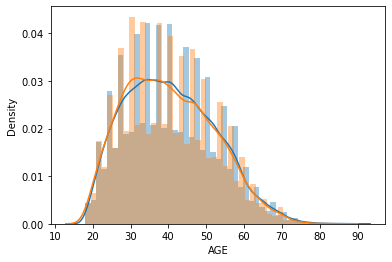

In [20]:
sns.distplot(train_data['AGE'])
sns.distplot(test_data['AGE'])

age_most_freq = train_data['AGE'].mode()[0]
train_data['AGE'] = train_data['AGE'].fillna(age_most_freq)
test_data['AGE'] = test_data['AGE'].fillna(age_most_freq)

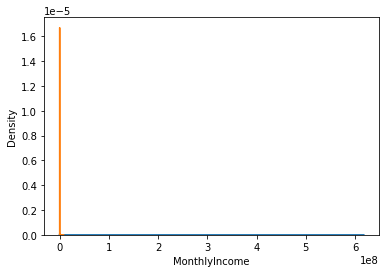

In [21]:
sns.distplot(train_data['MonthlyIncome'])
sns.distplot(test_data['MonthlyIncome'])
income_median = train_data['MonthlyIncome'].median()
train_data['MonthlyIncome'] = train_data['MonthlyIncome'].fillna(income_median)
test_data['MonthlyIncome'] = test_data['MonthlyIncome'].fillna(income_median)

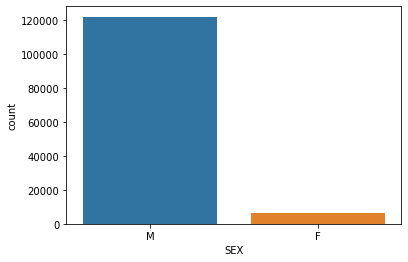

In [22]:
sns.countplot(train_data.SEX)
sns.countplot(test_data.SEX)
sex_most_freq = train_data['SEX'].mode()[0]
train_data['SEX'] = train_data['SEX'].fillna(sex_most_freq)
test_data['SEX'] = test_data['SEX'].fillna(sex_most_freq)


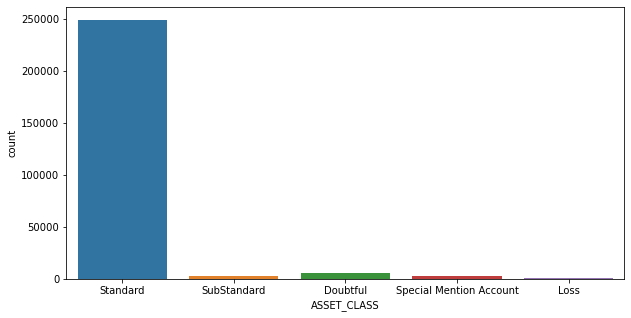

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(train_bureau.ASSET_CLASS)
sns.countplot(test_bureau.ASSET_CLASS)
asset_most_freq = train_bureau['ASSET_CLASS'].mode()[0]
train_bureau['ASSET_CLASS'] = train_bureau['ASSET_CLASS'].fillna(asset_most_freq)
test_bureau['ASSET_CLASS'] = test_bureau['ASSET_CLASS'].fillna(asset_most_freq)

<AxesSubplot:xlabel='CREDIT-LIMIT/SANC AMT', ylabel='Density'>

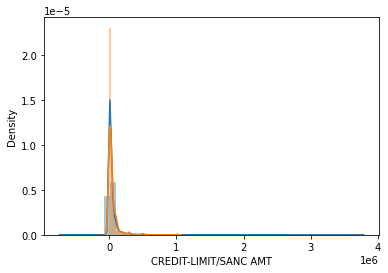

In [24]:
sns.distplot(train_bureau['CREDIT-LIMIT/SANC AMT'])
sns.distplot(test_bureau['CREDIT-LIMIT/SANC AMT'])


In [25]:
train_bureau['CREDIT-LIMIT/SANC AMT'] = train_bureau['CREDIT-LIMIT/SANC AMT'].fillna(0.0)
test_bureau['CREDIT-LIMIT/SANC AMT'] = test_bureau['CREDIT-LIMIT/SANC AMT'].fillna(0.0)

<AxesSubplot:xlabel='INSTALLMENT-AMT', ylabel='Density'>

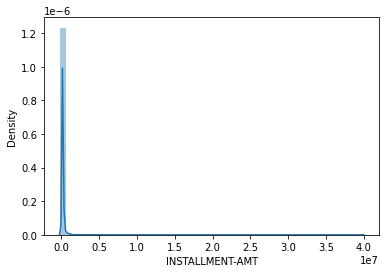

In [26]:
sns.distplot(train_bureau['INSTALLMENT-AMT'])

In [27]:
train_bureau['INSTALLMENT-AMT'] = train_bureau['INSTALLMENT-AMT'].fillna(0.0)
test_bureau['INSTALLMENT-AMT'] = test_bureau['INSTALLMENT-AMT'].fillna(0.0)

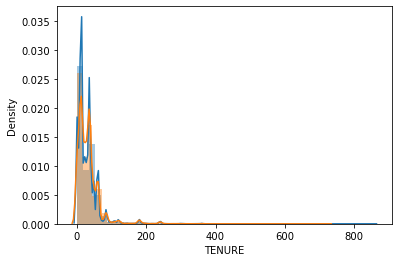

In [28]:
sns.distplot(train_bureau['TENURE'])
sns.distplot(test_bureau['TENURE'])
tenure_median = train_bureau['TENURE'].median()
train_bureau['TENURE'] = train_bureau['TENURE'].fillna(tenure_median)
test_bureau['TENURE'] = test_bureau['TENURE'].fillna(tenure_median)

In [29]:
all_data = pd.concat([train_data, test_data])
all_data = all_data.reset_index(drop=True)
print(all_data.shape)


(143400, 26)


# Feature Engineering:

> Extracting the whole values from the numerical features. Idea behind this is to avoid the minor differences and treating two values equally same

Example: 
        
        value1 = 100345 and value2 = 100045

        value1___whole_number = 100000 and value2___whole_number = 100000

In [30]:
for fe in ['DisbursalAmount', 
            'MonthlyIncome', 
            'AGE', 
            'Tenure', 
            'EMI', 
            'AssetCost']:
    print("Fetching whole number:",fe)
    all_data[fe+"___WHOLE_NUMBER"] = all_data[fe].apply(make_whole_number)

Fetching whole number: DisbursalAmount
Fetching whole number: MonthlyIncome
Fetching whole number: AGE
Fetching whole number: Tenure
Fetching whole number: EMI
Fetching whole number: AssetCost


In [31]:
all_data.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,...,City,State,ZiPCODE,Top-up Month,DisbursalAmount___WHOLE_NUMBER,MonthlyIncome___WHOLE_NUMBER,AGE___WHOLE_NUMBER,Tenure___WHOLE_NUMBER,EMI___WHOLE_NUMBER,AssetCost___WHOLE_NUMBER
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,...,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,200000,30000,40,40,20000,400000
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,...,SEHORE,MADHYA PRADESH,466001.0,No Top-up Service,300000,600,20,40,10000,400000
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,...,BHOPAL,MADHYA PRADESH,462030.0,12-18 Months,500000,40000,30,60,30000,600000
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,...,ASHOK NAGAR,MADHYA PRADESH,473335.0,> 48 Months,400000,20000,20,40,10000,400000
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,...,BILASPUR,CHATTISGARH,495442.0,36-48 Months,400000,20000,50,40,10000,600000


# Binning numeric features

In [32]:
binning_num_features = ['DisbursalAmount', 
                        'MonthlyIncome', 
                        'AGE', 
                        'Tenure', 
                        'EMI', 
                        'LTV',
                        'AssetCost'
                        ]
all_data = create_bin_features(all_data, binning_num_features)

Binning:  DisbursalAmount
Binning:  MonthlyIncome
Binning:  AGE
Binning:  Tenure
Binning:  EMI
Binning:  LTV
Binning:  AssetCost


# Outlier treatement

In [33]:
all_data = outlier_treatement(all_data, ['MonthlyIncome', 'AGE', 'EMI', 'DisbursalAmount', 'AssetCost','LTV', 'Tenure'])

16666.67 73750.0
26.0 57.0
14954.700000000004 87000.0
200000.0 480000.0
450000.0 670000.0
37.52 78.12
24.0 60.0


In [34]:
_len_train_demo = len(train_data)
train_data = all_data[: _len_train_demo].copy()
test_data = all_data[_len_train_demo:].copy()
print(train_data.shape, test_data.shape)

(128655, 46) (14745, 46)


# ANNOVA 

In [35]:
from scipy import stats

In [36]:
targets= train_data['Top-up Month'].unique()
for fe in ['DisbursalAmount','Tenure']:
    F, p = stats.f_oneway(
                          train_data[train_data['Top-up Month'] == targets[0]][fe],
                          train_data[train_data['Top-up Month'] == targets[1]][fe],
                          train_data[train_data['Top-up Month'] == targets[2]][fe],
                          train_data[train_data['Top-up Month'] == targets[3]][fe],
                          train_data[train_data['Top-up Month'] == targets[4]][fe],
                          train_data[train_data['Top-up Month'] == targets[5]][fe],
                          train_data[train_data['Top-up Month'] == targets[6]][fe],
                         )
    if p < 0.05:
        print('ANOVA: {} - {}:{}'.format(fe, F,p))


ANOVA: DisbursalAmount - 373.4898298560852:0.0
ANOVA: Tenure - 117.06733859263751:4.760210576690185e-148


In [37]:
train_data.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,...,EMI___BINS,LTV___BINS,AssetCost___BINS,MonthlyIncome___OUTLIERS,AGE___OUTLIERS,EMI___OUTLIERS,DisbursalAmount___OUTLIERS,AssetCost___OUTLIERS,LTV___OUTLIERS,Tenure___OUTLIERS
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,...,1,5,0,False,False,False,False,False,False,False
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,...,0,7,1,False,False,False,False,False,False,False
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,...,3,7,9,False,False,False,False,False,False,False
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,...,0,9,1,False,False,False,False,False,False,False
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,...,1,7,7,False,False,False,False,False,False,False


In [38]:
bureau_dup_mask = train_bureau.duplicated()

# merge_demographic_bureau_data:

> This function is the heart of feature engineering pipeline.

    > From categorical features added CountVectorizer like features

    > From numerical features created various aggregrated features

In [39]:
train_merged_data = merge_demographic_bureau_data(train_data, train_bureau[~bureau_dup_mask])
print(train_merged_data.shape)

(128655, 46) (556978, 25)
MATCH-TYPE
MATCH-TYPE___PRIMARY___COUNT
MATCH-TYPE___SECONDARY___COUNT
ACCT-TYPE
ACCT-TYPE___Overdraft___COUNT
ACCT-TYPE___Auto Loan (Personal)___COUNT
ACCT-TYPE___Tractor Loan___COUNT
ACCT-TYPE___Credit Card___COUNT
ACCT-TYPE___Commercial Vehicle Loan___COUNT
ACCT-TYPE___Gold Loan___COUNT
ACCT-TYPE___Consumer Loan___COUNT
ACCT-TYPE___Property Loan___COUNT
ACCT-TYPE___Personal Loan___COUNT
ACCT-TYPE___Two-Wheeler Loan___COUNT
ACCT-TYPE___Business Loan General___COUNT
ACCT-TYPE___Business Loan Priority Sector  Agriculture___COUNT
ACCT-TYPE___Kisan Credit Card___COUNT
ACCT-TYPE___Corporate Credit Card___COUNT
ACCT-TYPE___Business Non-Funded Credit Facility-Priority Sector-Agriculture___COUNT
ACCT-TYPE___Other___COUNT
ACCT-TYPE___Housing Loan___COUNT
ACCT-TYPE___Loan Against Shares / Securities___COUNT
ACCT-TYPE___Loan Against Bank Deposits___COUNT
ACCT-TYPE___Used Car Loan___COUNT
ACCT-TYPE___Loan to Professional___COUNT
ACCT-TYPE___Business Loan Priority Sector

In [40]:
train_merged_data.ID.value_counts()

51786     151
1167      127
28072     109
97794      87
28773      79
         ... 
13641       2
25111       2
132367      2
140555      2
2047        2
Name: ID, Length: 60803, dtype: int64

In [41]:
# dup_mask = train_merged_data[['ID','DisbursalAmount','NEXT_LOAN_IN_MONTHS']].duplicated()
dup_mask = train_merged_data[['ID']].duplicated()

print("#of duplicate records: {}".format(sum(dup_mask)))
train_merged_data = train_merged_data[~dup_mask]

#of duplicate records: 198434


In [42]:
print(train_merged_data['ACCT-TYPE'].value_counts()/train_merged_data.shape[0])

Tractor Loan                                     0.924477
Business Loan Priority Sector  Agriculture       0.036988
Other                                            0.008421
Gold Loan                                        0.007631
Two-Wheeler Loan                                 0.007204
Business Loan General                            0.005148
JLG Individual                                   0.001826
Auto Loan (Personal)                             0.001760
Consumer Loan                                    0.001612
Personal Loan                                    0.001003
Kisan Credit Card                                0.000954
Commercial Vehicle Loan                          0.000888
Credit Card                                      0.000855
Overdraft                                        0.000280
Loan Against Shares / Securities                 0.000263
Housing Loan                                     0.000197
Loan Against Bank Deposits                       0.000115
Used Car Loan 

In [43]:
train_merged_data[~dup_mask].ID.value_counts()[:5]

2049      1
85379     1
3435      1
13676     1
140654    1
Name: ID, dtype: int64

In [44]:
train_merged_data[train_merged_data.ID == 71060][['ID','NEXT_LOAN_IN_MONTHS']].head()

,ID,NEXT_LOAN_IN_MONTHS
309713,71060,0


In [45]:
bureau_dup_mask = test_bureau.duplicated()

In [46]:
test_merged_data = merge_demographic_bureau_data(test_data, test_bureau[~bureau_dup_mask])
print(test_merged_data.shape)

(14745, 46) (63331, 25)
MATCH-TYPE
MATCH-TYPE___PRIMARY___COUNT
MATCH-TYPE___SECONDARY___COUNT
ACCT-TYPE
ACCT-TYPE___Credit Card___COUNT
ACCT-TYPE___Property Loan___COUNT
ACCT-TYPE___Tractor Loan___COUNT
ACCT-TYPE___Gold Loan___COUNT
ACCT-TYPE___Consumer Loan___COUNT
ACCT-TYPE___Personal Loan___COUNT
ACCT-TYPE___Auto Loan (Personal)___COUNT
ACCT-TYPE___JLG Individual___COUNT
ACCT-TYPE___Two-Wheeler Loan___COUNT
ACCT-TYPE___Business Loan Priority Sector  Small Business___COUNT
ACCT-TYPE___Mudra Loans   Shishu / Kishor / Tarun___COUNT
ACCT-TYPE___Used Car Loan___COUNT
ACCT-TYPE___Business Loan General___COUNT
ACCT-TYPE___Other___COUNT
ACCT-TYPE___Business Loan Priority Sector  Agriculture___COUNT
ACCT-TYPE___Overdraft___COUNT
ACCT-TYPE___Commercial Vehicle Loan___COUNT
ACCT-TYPE___Kisan Credit Card___COUNT
ACCT-TYPE___Housing Loan___COUNT
ACCT-TYPE___Microfinance Business Loan___COUNT
ACCT-TYPE___Loan Against Bank Deposits___COUNT
ACCT-TYPE___Loan Against Shares / Securities___COUNT
ACCT

In [47]:
test_merged_data['ID'].value_counts()

69511     46
26305     38
114063    33
69953     32
68093     29
          ..
83899      2
69368      2
114612     2
4018       2
113798     2
Name: ID, Length: 7816, dtype: int64

In [48]:
# dup_mask = test_merged_data[['ID','DisbursalAmount','NEXT_LOAN_IN_MONTHS']].duplicated()
dup_mask = test_merged_data[['ID']].duplicated()

print("#of duplicate records: {}".format(sum(dup_mask)))
test_merged_data = test_merged_data[~dup_mask]
test_merged_data.ID.value_counts()[:5]

#of duplicate records: 23553


133121    1
70218     1
78515     1
97589     1
78507     1
Name: ID, dtype: int64

In [49]:
print(test_merged_data['ACCT-TYPE'].value_counts()/test_merged_data.shape[0])

Tractor Loan                                  0.975691
Two-Wheeler Loan                              0.006909
Business Loan Priority Sector  Agriculture    0.004606
Gold Loan                                     0.004094
Business Loan General                         0.003199
JLG Individual                                0.001151
Auto Loan (Personal)                          0.000896
Other                                         0.000768
Credit Card                                   0.000640
Kisan Credit Card                             0.000640
Personal Loan                                 0.000384
Commercial Vehicle Loan                       0.000256
Consumer Loan                                 0.000256
Business Loan Against Bank Deposits           0.000256
Loan Against Bank Deposits                    0.000128
Housing Loan                                  0.000128
Name: ACCT-TYPE, dtype: float64


# Target Distribution

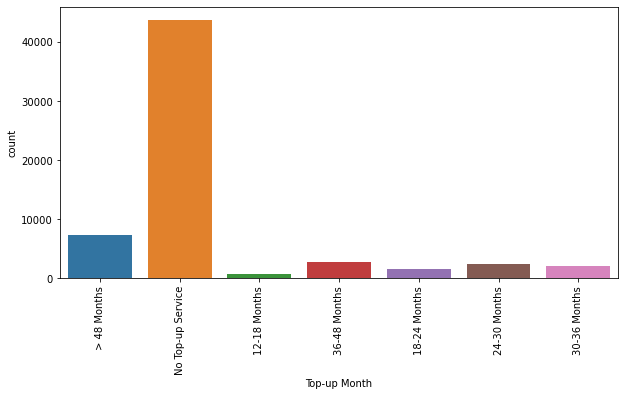

In [50]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.countplot(x=train_merged_data['Top-up Month']);

In [51]:
train_merged_data['Top-up Month'].value_counts()/len(train_merged_data)

No Top-up Service    0.719619
 > 48 Months         0.120455
36-48 Months         0.044784
24-30 Months         0.038781
30-36 Months         0.035607
18-24 Months         0.027581
12-18 Months         0.013174
Name: Top-up Month, dtype: float64

# Feature Selection

# Removing few features:

>  Removing all of the date features

>  Removing HIST features, because we have already extracted information from these

>  Removing features after running adversial validation. These features has different distribution in train and test file.

In [52]:
features_to_remove = [  
    'DisbursalDate', 
    'AuthDate',
    'DATE-REPORTED', 
    'DISBURSED-DT',
    'CLOSE-DT', 
    'LAST-PAYMENT-DATE', 
    'INSTALLMENT-FREQUENCY', 
    'REPORTED DATE - HIST', 
    'DPD - HIST', 
    'CUR BAL - HIST',
    'AMT OVERDUE - HIST', 
    'AMT PAID - HIST', 
    'AmountFinance', #Similar like DisbursalAmount
    'TENURE',
    
      #Removing these features: find out after running adversial validation
     'City', 
     'Area', 
     'AssetID', 
     'ZiPCODE', 
     'BranchID', 
     'ManufacturerID', 
     'State', 
     'ID', 
     'MaturityDAte',
     'SupplierID',
                      
]

In [53]:
X = train_merged_data.drop(['Top-up Month'] + features_to_remove, axis=1)
y = train_merged_data['Top-up Month']

In [54]:
X.shape, y.shape

((60803, 263), (60803,))

In [55]:
XTEST = test_merged_data.drop(features_to_remove, axis=1)

# Feature Engineering: 

> Added feature after finding how much loan repaid after different time-intervals :

    like till 18 months, till 24 months, etc...

In [56]:
loan_payment_freq_mapping = {
    'Monthly' : 1,
    'Quatrly': 3,
    'Half Yearly': 6,
    'BI-Monthly': 2
}

compound_interest_n_mapping = {
    'Monthly' : 12,
    'Quatrly': 4,
    'Half Yearly': 2,
    'BI-Monthly': 6
    
}
def loan_repayment_12_18(row):
    freq = row['Frequency']
    emi = row['EMI']
    tenure = row['Tenure']
    loan_amount = row['DisbursalAmount']
    final_amount = emi * (tenure // loan_payment_freq_mapping[freq])
    
    if tenure >= 18:
        loan_repaid = emi * (18 // loan_payment_freq_mapping[freq])
    else:
        loan_repaid = final_amount
    return loan_repaid / final_amount

def loan_repayment_upto_24(row):
    freq = row['Frequency']
    emi = row['EMI']
    tenure = row['Tenure']
    loan_amount = row['DisbursalAmount']
    final_amount = emi * (tenure // loan_payment_freq_mapping[freq])

    if tenure >= 24:
        loan_repaid = emi * (24 // loan_payment_freq_mapping[freq])
    else:
        loan_repaid = final_amount
    return loan_repaid / final_amount

def loan_repayment_upto_30(row):
    freq = row['Frequency']
    emi = row['EMI']
    tenure = row['Tenure']
    loan_amount = row['DisbursalAmount']
    final_amount = emi * (tenure // loan_payment_freq_mapping[freq])
    
    if tenure >= 30:
        loan_repaid = emi * (30 // loan_payment_freq_mapping[freq])
    else:
        loan_repaid = final_amount
    return loan_repaid / final_amount

def loan_repayment_upto_36(row):
    freq = row['Frequency']
    emi = row['EMI']
    tenure = row['Tenure']
    loan_amount = row['DisbursalAmount']
    final_amount = emi * (tenure // loan_payment_freq_mapping[freq])
    
    if tenure >= 36:
        loan_repaid = emi * (36 // loan_payment_freq_mapping[freq])
    else:
        loan_repaid = final_amount
    return loan_repaid / final_amount

def loan_repayment_upto_48(row):
    freq = row['Frequency']
    emi = row['EMI']
    tenure = row['Tenure']
    loan_amount = row['DisbursalAmount']
    final_amount = emi * (tenure // loan_payment_freq_mapping[freq])
    
    if tenure >= 48:
        loan_repaid = emi * (48 // loan_payment_freq_mapping[freq])
    else:
        loan_repaid = final_amount
    return loan_repaid / final_amount

In [57]:
X['loan_repaid_upto_18_months'] = X.apply(loan_repayment_12_18, axis=1)
XTEST['loan_repaid_upto_18_months'] = XTEST.apply(loan_repayment_12_18, axis=1)

X['loan_repaid_upto_24_months'] = X.apply(loan_repayment_upto_24, axis=1)
XTEST['loan_repaid_upto_24_months'] = XTEST.apply(loan_repayment_upto_24, axis=1)

X['loan_repaid_upto_30_months'] = X.apply(loan_repayment_upto_30, axis=1)
XTEST['loan_repaid_upto_30_months'] = XTEST.apply(loan_repayment_upto_30, axis=1)

X['loan_repaid_upto_36_months'] = X.apply(loan_repayment_upto_36, axis=1)
XTEST['loan_repaid_upto_36_months'] = XTEST.apply(loan_repayment_upto_36, axis=1)

X['loan_repaid_upto_48_months'] = X.apply(loan_repayment_upto_48, axis=1)
XTEST['loan_repaid_upto_48_months'] = XTEST.apply(loan_repayment_upto_48, axis=1)

# Target and Categorical Feature Encoding

In [58]:
target_encoder = LabelEncoder()

In [59]:
y_trans= target_encoder.fit_transform(y)

In [60]:
for col in X.select_dtypes('object'):
    print("Encoding :", col)
    le = LabelEncoder()
    le.fit(list(X[col]) + list(XTEST[col]))
    X[col] = le.transform(X[col])
    XTEST[col] = le.transform(XTEST[col])

Encoding : Frequency
Encoding : InstlmentMode
Encoding : LoanStatus
Encoding : PaymentMode
Encoding : SEX
Encoding : MATCH-TYPE
Encoding : ACCT-TYPE
Encoding : CONTRIBUTOR-TYPE
Encoding : OWNERSHIP-IND
Encoding : ACCOUNT-STATUS
Encoding : ASSET_CLASS
Encoding : NEXT_LOAN_BUCKET


In [61]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60803 entries, 2 to 556965
Columns: 268 entries, Frequency to loan_repaid_upto_48_months
dtypes: bool(9), float64(138), int64(121)
memory usage: 123.1 MB


In [62]:
XTEST.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7816 entries, 3 to 63258
Columns: 259 entries, Frequency to loan_repaid_upto_48_months
dtypes: bool(9), float64(139), int64(110), object(1)
memory usage: 15.0+ MB


In [63]:
X.shape, XTEST.shape

((60803, 268), (7816, 259))

In [64]:
features_missing_from_test_data = set(X.columns) - set(XTEST.columns)

In [65]:
XTEST[list(features_missing_from_test_data)] = 0

In [66]:
XTEST = XTEST[X.columns]

In [67]:
X.shape, XTEST.shape

((60803, 268), (7816, 268))

# Benchmarking different models:

> LGB

> XGB

> Ensmeble : 0.5* LGB + 0.5 * XGB

In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_trans, test_size=0.2, random_state=SEED, stratify=y_trans)

In [69]:
current_best = (0.5904478029251055, {'bagging_fraction': 0.9648178267940851, 'bagging_freq': 5, 'feature_fraction': 0.7864711972326701, 'lambda_l1': 0.05, 'lambda_l2': 3.3000000000000003, 'learning_rate': 0.025, 'max_bin': 255, 'max_depth': 15, 'metric': 'multi_logloss', 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 5.068990408995694, 'num_class': 7, 'num_leaves': 21, 'objective': 'multiclass', 'seed': 2021, 'verbose': -1}, 372)
    

In [70]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

In [71]:
param = current_best[1].copy()
param

{'bagging_fraction': 0.9648178267940851,
 'bagging_freq': 5,
 'feature_fraction': 0.7864711972326701,
 'lambda_l1': 0.05,
 'lambda_l2': 3.3000000000000003,
 'learning_rate': 0.025,
 'max_bin': 255,
 'max_depth': 15,
 'metric': 'multi_logloss',
 'min_data_in_leaf': 92,
 'min_sum_hessian_in_leaf': 5.068990408995694,
 'num_class': 7,
 'num_leaves': 21,
 'objective': 'multiclass',
 'seed': 2021,
 'verbose': -1}

In [72]:
bst = lgb.train(param, train_data, NUM_OF_BOOST_ROUND, 
                valid_sets=[train_data, valid_data], 
                early_stopping_rounds= EARLY_STOPPING, 
                verbose_eval=100)

Training until validation scores don't improve for 300 rounds
[100]	training's multi_logloss: 0.44521	valid_1's multi_logloss: 0.47983
[200]	training's multi_logloss: 0.389927	valid_1's multi_logloss: 0.455696
[300]	training's multi_logloss: 0.355847	valid_1's multi_logloss: 0.449866
[400]	training's multi_logloss: 0.328787	valid_1's multi_logloss: 0.447689
[500]	training's multi_logloss: 0.305776	valid_1's multi_logloss: 0.447166
[600]	training's multi_logloss: 0.285439	valid_1's multi_logloss: 0.44736
[700]	training's multi_logloss: 0.267312	valid_1's multi_logloss: 0.447885
[800]	training's multi_logloss: 0.250908	valid_1's multi_logloss: 0.448884
Early stopping, best iteration is:
[515]	training's multi_logloss: 0.302566	valid_1's multi_logloss: 0.447071


In [73]:
# Predict Validation
ypred_valid = bst.predict(X_valid, num_iteration=bst.best_iteration)
f1_score(y_valid, np.argmax(ypred_valid, axis=1), average='macro')

0.6775956600977912

In [74]:
f_importance_df = pd.DataFrame(bst.feature_importance(), columns=['importance'], index=X_valid.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)

In [75]:
top_features = f_importance_df['importance'][:30].index
top_features

Index(['CUR_BAL_HIST_TOTAL', 'NEXT_LOAN_IN_MONTHS', 'EMI_INCOME_RATO', 'LTV',
       'ACCT-TYPE___Gold Loan___COUNT', 'MonthlyIncome',
       'CUR_BAL_HIST_TOTAL___LESS_THAN_12_BUCKET___MEAN', 'EMI', 'CURRENT-BAL',
       'AssetCost', 'OLD_NEW_LOAN_RATIO____MEAN_PER_CUSTOMER',
       'DISBURSED-AMT/HIGH CREDIT', 'CUR_BAL_HIST_TOTAL____MEAN_PER_CUSTOMER',
       'INSTALLMENT-AMT____MEAN_PER_CUSTOMER',
       'AMT_OVERDUE_HIST_TOTAL____MEAN_PER_CUSTOMER', 'DisbursalAmount',
       'CURRENT-BAL____MEAN_PER_CUSTOMER', 'Tenure',
       'DISBURSED-AMT/HIGH CREDIT____MEAN_PER_CUSTOMER',
       'CURRENT-BAL___WHOLE_NUMBER____MEAN_PER_CUSTOMER', 'AGE',
       'AGE_WHEN_LOAN_COMPLETES', 'AMT_PAID_HIST_TOTAL____MEAN_PER_CUSTOMER',
       'AMT_OVERDUE_HIST_TOTAL___LESS_THAN_12_BUCKET___MEAN',
       'DISBURSED-AMT/HIGH CREDIT___LESS_THAN_12_BUCKET___MEAN',
       'ACCT-TYPE___Personal Loan___COUNT',
       'DISBURSED-AMT/HIGH CREDIT___WHOLE_NUMBER____MEAN_PER_CUSTOMER',
       'PaymentMode', 'CURR

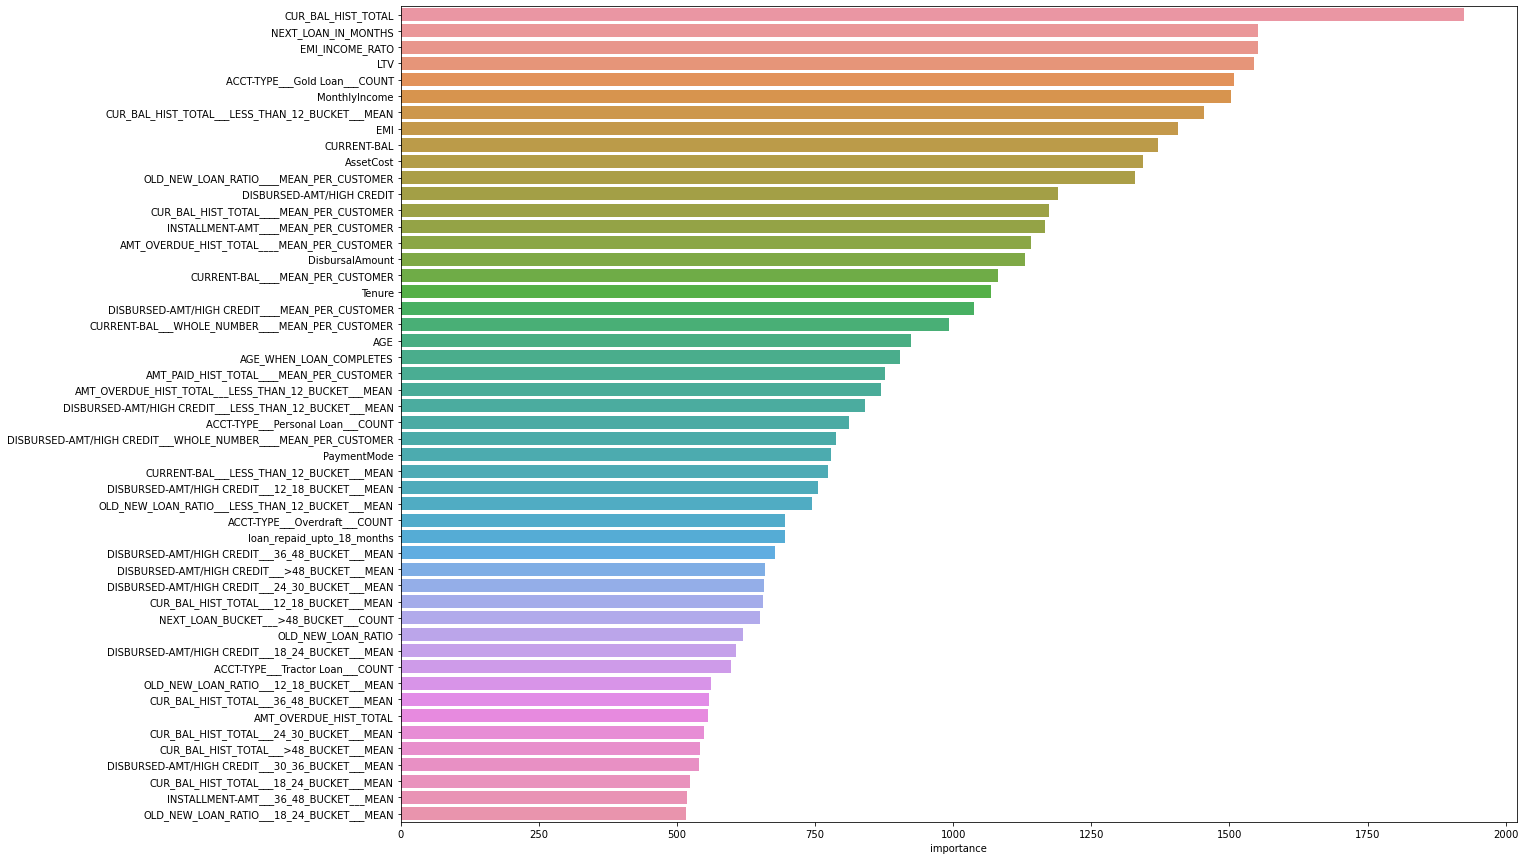

In [76]:
plt.figure(figsize=(20,15))
sns.barplot(x=f_importance_df.importance[:50], y=f_importance_df.index[:50]);

# XGB

In [77]:
xgb_train_data = xgb.DMatrix(X_train, label=y_train)
xgb_valid_data = xgb.DMatrix(X_valid, label=y_valid)
xgb_current_best = (0.5992587341153869, {'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.45, 'eval_metric': 'mlogloss', 'gamma': 0.75, 'max_depth': 5, 'min_child_weight': 4.0, 'num_class': 7, 'objective': 'multi:softprob', 'reg_alpha': 0.1, 'reg_lambda': 1.9000000000000001, 'seed': 2021, 'silent': 1, 'subsample': 0.9500000000000001, 'tree_method': 'hist'}, 30)
xgb_params = xgb_current_best[1].copy()
xgb_bst = xgb.train(xgb_params, xgb_train_data, NUM_OF_BOOST_ROUND, 
                evals=[(xgb_train_data, 'train'), (xgb_valid_data, 'eval')], 
                early_stopping_rounds= EARLY_STOPPING, 
                verbose_eval=100)

[15:43:52] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.06147	eval-mlogloss:1.06754
[100]	train-mlogloss:0.23650	eval-mlogloss:0.46171
[200]	train-mlogloss:0.14870	eval-mlogloss:0.47708
[300]	train-mlogloss:0.10912	eval-mlogloss:0.48939
[349]	train-mlogloss:0.09800	eval-mlogloss:0.49310


In [78]:
xgb_ypred_valid = xgb_bst.predict(xgb_valid_data, ntree_limit=xgb_bst.best_ntree_limit)
f1_score(y_valid, np.argmax(xgb_ypred_valid, axis=1), average='macro')

0.6687140225696764

In [79]:
ensemble_ypred_valid = 0.5 * ypred_valid + 0.5 * xgb_ypred_valid
f1_score(y_valid, np.argmax(ensemble_ypred_valid, axis=1), average='macro')

0.6705701847072769

# OOF (Out Of Fold) Prediction:

![Model_with_selected_features](https://github.com/asingleneuron/edgeverve_ml_challenge/blob/master/images/OOF_PREDICTION.png?raw=True)

In [80]:
if OOF_PREDICTION:
    best_param = current_best[1]
    xgb_params = xgb_current_best[1].copy()

    
    num_splits = NUM_OF_SPLITS
    skf = StratifiedKFold(n_splits= num_splits, random_state=SEED, shuffle=False)
    oof_predictions = np.zeros((X.shape[0], 7)) 

    y_test_pred = np.zeros((XTEST.shape[0], 7)) 
    y_test_pred_xgb = np.zeros((XTEST.shape[0], 7)) 
    y_test_pred_ensemble = np.zeros((XTEST.shape[0], 7)) 
    

    print(y_test_pred.shape)
    y_valid_scores = []
    y_valid_scores_xgb = []
    y_valid_scores_ensemble = []

    fold_cnt = 1
    for train_index, test_index in skf.split(X,y_trans):
        print("FOLD .... ",fold_cnt)
        fold_cnt += 1

        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y_trans[train_index], y_trans[test_index]
        
        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_valid, label=y_valid)

        # Training lgb model
        num_round = NUM_OF_BOOST_ROUND
        bst = lgb.train(best_param, dtrain, num_round,
                              valid_sets=[dtrain, dvalid],
                              verbose_eval=100,
                              early_stopping_rounds=EARLY_STOPPING,
#                               feval=F1_MACRO
                             )
        # Predict Validation
        y_pred_valid = bst.predict(X_valid, num_iteration=bst.best_iteration)
        y_valid_scores.append(f1_score(y_valid, np.argmax(y_pred_valid, axis=1), average='macro'))

        # Predict Test 
        y_pred = bst.predict(XTEST, num_iteration=bst.best_iteration)

        y_test_pred += y_pred
        
        #XGB
        xgb_train_data = xgb.DMatrix(X_train, label=y_train)
        xgb_valid_data = xgb.DMatrix(X_valid, label=y_valid)
        xgb_params = xgb_current_best[1].copy()
        xgb_bst = xgb.train(xgb_params, xgb_train_data, NUM_OF_BOOST_ROUND, 
                evals=[(xgb_train_data, 'train'), (xgb_valid_data, 'eval')], 
                early_stopping_rounds= EARLY_STOPPING, 
                verbose_eval=100)
        xgb_ypred_valid = xgb_bst.predict(xgb_valid_data, ntree_limit=xgb_bst.best_ntree_limit)
        y_valid_scores_xgb.append(f1_score(y_valid, np.argmax(xgb_ypred_valid, axis=1), average='macro'))
        y_pred_xgb = xgb_bst.predict(xgb.DMatrix(XTEST), ntree_limit=xgb_bst.best_ntree_limit)
        y_test_pred_xgb += y_pred_xgb
        
        #Ensemble
        ypred_ensemble = 0.5 * y_pred_valid + 0.5 * xgb_ypred_valid
        y_valid_scores_ensemble.append(f1_score(y_valid, np.argmax(ypred_ensemble, axis=1), average='macro'))
        y_test_pred_ensemble += (0.5 * y_test_pred + 0.5 * y_test_pred_xgb)


    #Normalize test predicted probability
    y_test_pred /= num_splits
    y_test_pred_xgb /= num_splits
    y_test_pred_ensemble /= num_splits

(7816, 7)
FOLD ....  1
Training until validation scores don't improve for 300 rounds
[100]	training's multi_logloss: 0.439789	valid_1's multi_logloss: 0.51856
[200]	training's multi_logloss: 0.384862	valid_1's multi_logloss: 0.497795
[300]	training's multi_logloss: 0.351318	valid_1's multi_logloss: 0.494807
[400]	training's multi_logloss: 0.324702	valid_1's multi_logloss: 0.494391
[500]	training's multi_logloss: 0.301714	valid_1's multi_logloss: 0.495003
[600]	training's multi_logloss: 0.281323	valid_1's multi_logloss: 0.496372
Early stopping, best iteration is:
[349]	training's multi_logloss: 0.337628	valid_1's multi_logloss: 0.494037
[15:47:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.05362	eva

In [81]:
print(y_valid_scores)
print("Average validation_score: ",np.mean(y_valid_scores))

[0.6208384511101811, 0.6503458561467355, 0.7193687335823485, 0.7107993639396764, 0.6843931095614735]
Average validation_score:  0.6771491028680829


In [82]:
print(y_valid_scores_xgb)
print("Average validation_score: ",np.mean(y_valid_scores_xgb))

[0.6104589410019703, 0.6397169459190339, 0.7106621462035809, 0.7010919166427253, 0.6801322749532864]
Average validation_score:  0.6684124449441193


In [83]:
print(y_valid_scores_ensemble)
print("Average validation_score: ",np.mean(y_valid_scores_ensemble))

[0.6182841655206124, 0.6495814673223056, 0.7161323027945168, 0.7083211854785336, 0.6823117114202334]
Average validation_score:  0.6749261665072404


In [84]:
ytest_lgb_target = target_encoder.inverse_transform(np.argmax(y_test_pred, axis=1))
ytest_xgb_target = target_encoder.inverse_transform(np.argmax(y_test_pred_xgb, axis=1))
ytest_ens_target = target_encoder.inverse_transform(np.argmax(y_test_pred_ensemble, axis=1))


In [85]:
dummy = test_merged_data[['ID']].copy()
dummy['lgb_pred'] = ytest_lgb_target
dummy['xgb_pred'] = ytest_xgb_target
dummy['ensemble_pred'] = ytest_ens_target

dummy = dummy.set_index(['ID'])
dummy.head()

,lgb_pred,xgb_pred,ensemble_pred
ID,,,
4,No Top-up Service,No Top-up Service,No Top-up Service
5,No Top-up Service,> 48 Months,No Top-up Service
6,No Top-up Service,No Top-up Service,No Top-up Service
126,No Top-up Service,No Top-up Service,No Top-up Service
127,No Top-up Service,No Top-up Service,No Top-up Service


In [86]:
def get_target(_id):
    if _id in dummy.index:
        return dummy.loc[_id]['lgb_pred']
    else:
        return "No Top-up Service"

def get_target_xgb(_id):
    if _id in dummy.index:
        return dummy.loc[_id]['xgb_pred']
    else:
        return "No Top-up Service"
    
def get_target_ensemble(_id):
    if _id in dummy.index:
        return dummy.loc[_id]['ensemble_pred']
    else:
        return "No Top-up Service"
    

# LGB

In [87]:
sample_sub['Top-up Month'] = sample_sub['ID'].apply(get_target)
print(sample_sub['Top-up Month'].value_counts())
print("")
print(sample_sub['Top-up Month'].value_counts()/len(sample_sub))
sample_sub.to_csv("lgb_submission.csv", index=False)

No Top-up Service    13648
 > 48 Months           554
36-48 Months           184
18-24 Months            98
30-36 Months            97
24-30 Months            94
12-18 Months            70
Name: Top-up Month, dtype: int64

No Top-up Service    0.925602
 > 48 Months         0.037572
36-48 Months         0.012479
18-24 Months         0.006646
30-36 Months         0.006579
24-30 Months         0.006375
12-18 Months         0.004747
Name: Top-up Month, dtype: float64


# XGB

In [88]:
sample_sub['Top-up Month'] = sample_sub['ID'].apply(get_target_xgb)
print(sample_sub['Top-up Month'].value_counts())
print("")
print(sample_sub['Top-up Month'].value_counts()/len(sample_sub))
sample_sub.to_csv("xgb_submission.csv", index=False)

No Top-up Service    13666
 > 48 Months           558
36-48 Months           172
18-24 Months            97
30-36 Months            95
24-30 Months            88
12-18 Months            69
Name: Top-up Month, dtype: int64

No Top-up Service    0.926823
 > 48 Months         0.037843
36-48 Months         0.011665
18-24 Months         0.006579
30-36 Months         0.006443
24-30 Months         0.005968
12-18 Months         0.004680
Name: Top-up Month, dtype: float64


# Ensemble

In [89]:
sample_sub['Top-up Month'] = sample_sub['ID'].apply(get_target_ensemble)
print(sample_sub['Top-up Month'].value_counts())
print("")
print(sample_sub['Top-up Month'].value_counts()/len(sample_sub))
sample_sub.to_csv("ensemble_submission.csv", index=False)

No Top-up Service    13659
 > 48 Months           567
36-48 Months           172
18-24 Months            96
24-30 Months            93
30-36 Months            92
12-18 Months            66
Name: Top-up Month, dtype: int64

No Top-up Service    0.926348
 > 48 Months         0.038454
36-48 Months         0.011665
18-24 Months         0.006511
24-30 Months         0.006307
30-36 Months         0.006239
12-18 Months         0.004476
Name: Top-up Month, dtype: float64
